In [33]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [34]:
from google.colab import files
upload = files.upload()

Saving 3-class.csv to 3-class (1).csv


In [35]:
up_list = files.upload()

Saving list.txt to list (1).txt


In [36]:
!mkdir outputs
!pip3 install keras_metrics

mkdir: cannot create directory ‘outputs’: File exists


In [0]:
# -*- coding: utf-8 -*-
#-------------------------------------------------------------------------------

import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


import re
from keras import regularizers
import sys
import codecs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
#from nltk.stem.arlstem import ARLSTem
import gensim
from gensim.models.word2vec import Word2Vec


import keras
from keras import layers
from keras import optimizers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
import keras_metrics
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

from keras.engine.topology import Layer

In [39]:
from keras.utils import get_file
cbow = get_file('cbow_100.zip', 'https://archive.org/download/aravec2.0/tweet_cbow_100.zip', extract=True)
cbow

'/root/.keras/datasets/cbow_100.zip'

In [40]:
!ls /root/.keras/datasets/

cbow_100.zip	 tweets_cbow_100.trainables.syn1neg.npy
tweets_cbow_100  tweets_cbow_100.wv.vectors.npy


In [0]:
from pathlib import Path
cbow_path = Path('/root/.keras/datasets/tweets_cbow_100')

In [0]:
import keras.backend as K
K.clear_session()

In [43]:
data = pd.read_csv('3-class.csv', encoding='utf-8')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(56674, 2)


,Tweet,Polarity
0,رفع_اسعار_البنزين_والكهرباا بعد منظر العالم ا...,neg
1,حرق قنصليه السعوديه في مدينه مشهد الايرانيه ب...,neut
2,الف مبروك هلالنا الهلال_الشباب,pos
3,السماح_بالسينما_في_السعوديه السينما وجودها لا...,neut
4,دونيس لخص تاريخ الهلال بتصريح واحد فقط حين قا...,neut


In [44]:
data.sample(frac=1)

,Tweet,Polarity
29968,نتائج مباريات دوري_ابطال_اوروبا رياضه برشلونه_...,neut
36875,اوامر_ملكيه شافوه مرن الله لايثمر فيهم,neg
14243,لانريد تعليق_الدراسه بل نريد تعليق رؤوس الفسا...,neg
29561,تعليق_الدراسه_في_القصيم يارب يعلقونه علي اختب...,neut
35554,زرت سوريه بعد 9 اشهر من اندلاع الثوره في اطار...,neg
...,...,...
9918,اليوم هاجدين عشان مافيه تعليق احسن خلاص ي الشع...,neg
51631,دائما ما اكررها اهلي مع جروس يغيب من يغيب لكن...,pos
21123,مايجيب االسكري غيركم لازم نشوف لتا اتجاه اخر,neg
54956,حذف_قناه_العربيه_من_الريسيفر كل من يطالب بحذف...,neg


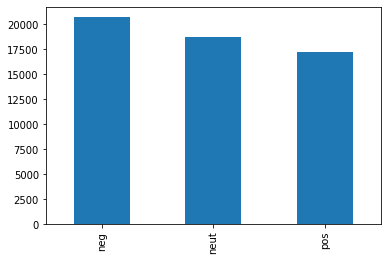

In [45]:
data['Polarity'].value_counts().sort_index().plot.bar()

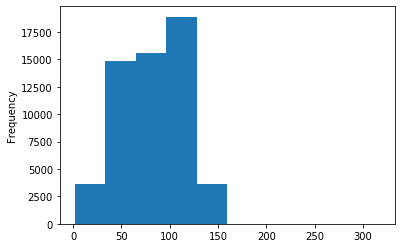

In [46]:
data['Tweet'].str.len().plot.hist()

In [47]:
def transform(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return 2
data['Sentiment'] = data['Polarity'].apply(transform)
data.head()

,Tweet,Polarity,Sentiment
0,رفع_اسعار_البنزين_والكهرباا بعد منظر العالم ا...,neg,0
1,حرق قنصليه السعوديه في مدينه مشهد الايرانيه ب...,neut,2
2,الف مبروك هلالنا الهلال_الشباب,pos,1
3,السماح_بالسينما_في_السعوديه السينما وجودها لا...,neut,2
4,دونيس لخص تاريخ الهلال بتصريح واحد فقط حين قا...,neut,2


In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
#remove users
data['clean'] = data['Tweet'].apply(lambda x: re.sub('(@[A-Za-z]+)', '', x, flags=re.UNICODE))

#remove hashtags
#data['clean'] = data['clean'].apply(lambda x: re.sub('([أ-ي]+_[أ-ي]+)', '', x, flags=re.UNICODE))
#data['clean'] = data['clean'].apply(lambda x: re.sub('(_[أ-ي]+)', '', x, flags=re.UNICODE))
data['clean'] = data['clean'].apply(lambda x: re.sub('(_)', ' ', x, flags=re.UNICODE))
#remove letters, numbers & symbols
data['clean'] = data['clean'].apply(lambda x: re.sub('[a-zA-Z0-9@=$:.،%^*"#~£/&\n؟?!-_]', '', x, flags=re.UNICODE))

#arabic numbers
data['clean'] = data['clean'].apply(lambda x: re.sub('[٠١٢٣٤٥٦٧٨٩]', '', x, flags=re.UNICODE))

#nltk tokenize
data['clean'].apply(word_tokenize)
data['clean'] = data['clean'].apply(word_tokenize) 

#repeated letters
data['clean']= data['clean'].apply(lambda x: [''.join(ch for ch, _ in itertools.groupby(y)) for y in x])

#normalization
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)
data['clean']= data['clean'].apply(lambda x: [normalizeArabic(y) for y in x])

#remove stopwords
def get_stop_words():
    path = 'list.txt'
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

stop_words = get_stop_words()
data['clean']= data['clean'].apply(lambda x: [item for item in x if item not in stop_words])

#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean']= data['clean'].apply(lambda x: [remove_emoji(y) for y in x])

data.head(10)

,Tweet,Polarity,Sentiment,clean
0,رفع_اسعار_البنزين_والكهرباا بعد منظر العالم ا...,neg,0,"[رفع, اسعار, البنزين, والكهربا, منظر, العالم, ..."
1,حرق قنصليه السعوديه في مدينه مشهد الايرانيه ب...,neut,2,"[حرق, قنصليه, السعوديه, مدينه, مشهد, الايرانيه..."
2,الف مبروك هلالنا الهلال_الشباب,pos,1,"[مبروك, هلالنا, الهلال, الشباب]"
3,السماح_بالسينما_في_السعوديه السينما وجودها لا...,neut,2,"[السماح, بالسينما, السعوديه, السينما, وجودها, ..."
4,دونيس لخص تاريخ الهلال بتصريح واحد فقط حين قا...,neut,2,"[دونيس, لخص, تاريخ, الهلال, بتصريح, نريد, الحك..."
5,رسوم_الاراضي_البيضاا اللافت في القرار النص عل...,neut,2,"[رسوم, الاراضي, البيضا, الافت, القرار, النص, ح..."
6,ملخص الاهداف سهره ولا اروع تصبحون على خير برش...,pos,1,"[ملخص, الاهداف, سهره, اروع, تصبحون, خير, برشلو..."
7,الف مبروك يا الهلال على مستوى يا الهلال انشاا ...,pos,1,"[مبروك, الهلال, مستوي, الهلال, انشا, يتعادل, ا..."
8,الهلال تعادلل,neut,2,"[الهلال, تعادل]"
9,بي بي سي تكتب عن المجاهد عبدالحميد اباعود المن...,neut,2,"[بي, بي, سي, تكتب, المجاهد, عبدالحميد, اباعود,..."


In [51]:
CBOW = Word2Vec.load(str(cbow_path))
CBOWE = CBOW.wv.get_keras_embedding()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
y = to_categorical(data['Sentiment'].values)

In [53]:
tokenizer = Tokenizer(num_words=len(data['clean']), split=" ")
tokenizer.fit_on_texts(data['clean'].values)

X = tokenizer.texts_to_sequences(data['clean'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    14,    16,    15,    19,  4644,   124,   785,  1022,
           52,  8961,   269,  1896,   875,  9986,  2112,   152, 15158],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         3063,  8110,     3,   575,  1842,  2175,    97,    89,    21],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    12,   927,     1,    40],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    22,    24,
            3,   138,  5201,  1203, 35697,   805, 18660,  1698,   245],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    58, 35698,   494,
  

In [54]:
X.shape

(56674, 27)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
#Metrics
def plot_data(H, EPOCHS, name='figure.png'):
    # plot the losses
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, EPOCHS), H['acc'],
        label="Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['val_acc'],
        label="Val_Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['loss'],
        label="Loss")
    plt.plot(np.arange(0, EPOCHS), H['val_loss'],
        label="Val_Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy & Loss")
    plt.legend(loc="upper right")
    plt.show()
    if name:
        plt.savefig(name)

In [0]:
#calculation
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# metrics all
metrics = [
    'accuracy',
    keras_metrics.precision(),
    keras_metrics.recall(),
    f1,
]

In [0]:
# hyperparamters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
EPOCHS = 20

In [0]:
#build model
def buildAndRunModel(model, ckpt_path):
    # callbacks
    checkpoints = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=False)
    
    model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=metrics,)
    H = model.fit(X_train, y_train, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS,
               callbacks=[checkpoints],)
    return H

In [0]:
def eval_model(model):
    E = model.evaluate(X_test, y_test)
    return list(zip(E, model.metrics_names))

In [0]:
#GRU

gru_model_input = layers.Input(shape=(X_train.shape[1],))
x = CBOWE(gru_model_input)
x = layers.GRU(100, return_sequences=True, dropout=0.5)(x)
x = layers.GRU(100, return_sequences=True, dropout=0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu', name='desne1')(x)
x = layers.Dense(3, activation='softmax', name='desne_output')(x)

gru_model = keras.models.Model(inputs=gru_model_input, outputs=x)

In [65]:
gru_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 27)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 27, 100)           33167900  
_________________________________________________________________
gru_1 (GRU)                  (None, 27, 100)           60300     
_________________________________________________________________
gru_2 (GRU)                  (None, 27, 100)           60300     
_________________________________________________________________
flatten_2 (Flatten)          (None, 2700)              0         
_________________________________________________________________
desne1 (Dense)               (None, 100)               270100    
_________________________________________________________________
desne_output (Dense)         (None, 3)                 303 

In [66]:
%%time
GRU_H = buildAndRunModel(gru_model, 'gru_ckpt')

Train on 36271 samples, validate on 9068 samples
Epoch 1/20
36271/36271 [==============================] - 89s 2ms/step - loss: 1.0423 - acc: 0.4557 - precision: 0.5153 - recall: 0.1485 - f1: 0.2223 - val_loss: 0.9098 - val_acc: 0.5766 - val_precision: 0.5849 - val_recall: 0.5705 - val_f1: 0.5485
Epoch 2/20
36271/36271 [==============================] - 86s 2ms/step - loss: 0.9260 - acc: 0.5579 - precision: 0.5913 - recall: 0.3874 - f1: 0.4765 - val_loss: 0.8459 - val_acc: 0.6165 - val_precision: 0.6126 - val_recall: 0.6346 - val_f1: 0.5896
Epoch 3/20
36271/36271 [==============================] - 85s 2ms/step - loss: 0.8802 - acc: 0.5918 - precision: 0.6202 - recall: 0.4759 - f1: 0.5328 - val_loss: 0.8452 - val_acc: 0.6288 - val_precision: 0.6167 - val_recall: 0.6721 - val_f1: 0.6144
Epoch 4/20
36271/36271 [==============================] - 85s 2ms/step - loss: 0.8525 - acc: 0.6052 - precision: 0.6425 - recall: 0.5132 - f1: 0.5596 - val_loss: 0.8164 - val_acc: 0.6457 - val_precision: 

In [67]:
eval_model(gru_model)

11335/11335 [==============================] - 11s 984us/step


[(0.7577069525104501, 'loss'),
 (0.6774591971874027, 'acc'),
 (0.6701056251370645, 'precision'),
 (0.6730816678837138, 'recall'),
 (0.6578766192641088, 'f1')]

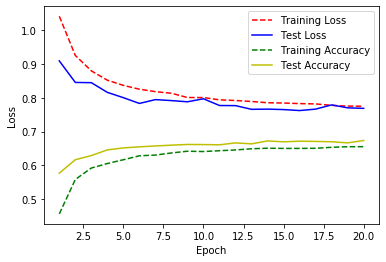

In [69]:
training_loss = GRU_H.history['loss']
test_loss = GRU_H.history['val_loss']
training_acc = GRU_H.history['acc']
test_acc = GRU_H.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.plot(epoch_count, training_acc, 'g--')
plt.plot(epoch_count, test_acc, 'y-')
plt.legend(['Training Loss', 'Test Loss', 'Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();